In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [17]:
df = pd.read_csv('dataCarSale2021-2025.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    54 non-null     float64
 1   HONDA       54 non-null     float64
 2   MITSUBISHI  54 non-null     float64
 3   SUZUKI      54 non-null     float64
 4   TOYOTA      54 non-null     float64
dtypes: float64(5)
memory usage: 2.5 KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA
count     54.000000     54.000000     54.000000     54.000000     54.000000
mean   11254.531630   7645.139556   8760.141000   5609.579630  19934.127907
std     4597.871605   3886.261244   3351.676613   2351.526395   7855.556087
min     5755.232000   1590.411000   4349.666000   2004.813000   7617.122000
25%     7477.087250   3855.075250   6204.000000   3227.915000  12472.187250
50%     9310.389000   7725.500000   7637.046000   5830.500000  20983.500000
75%    15638.000000

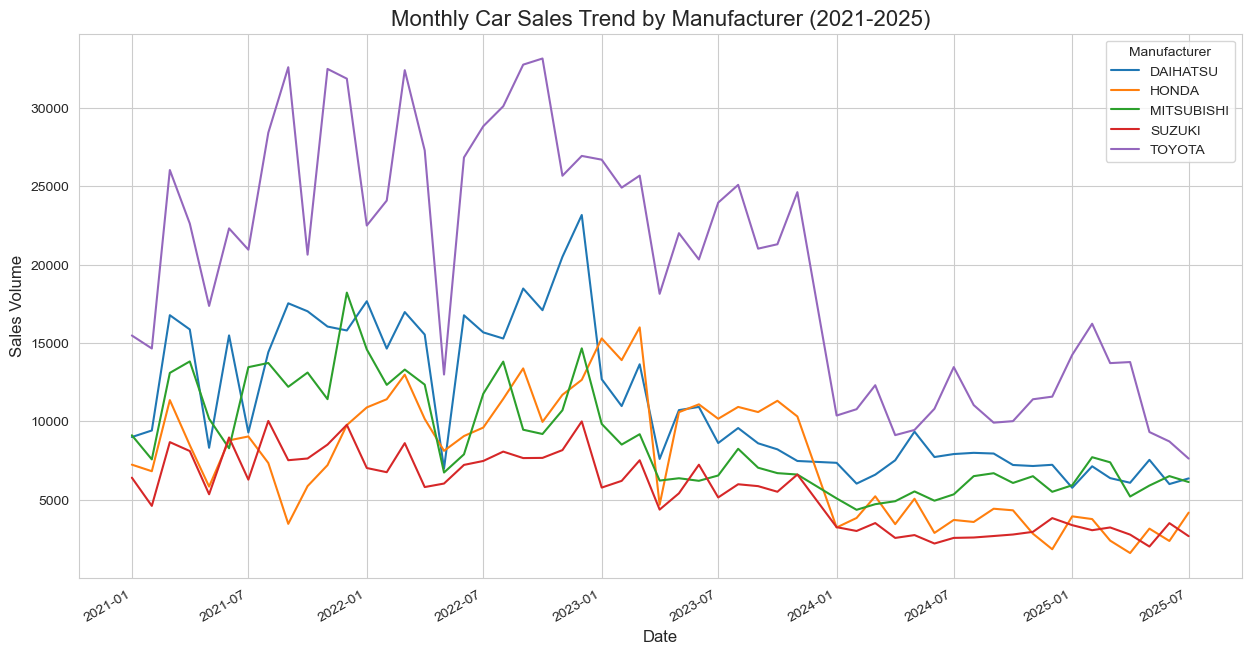

In [18]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [19]:
# Calculate total sales to use as the target variable
df['TOTAL_SALES'] = df.sum(axis=1)

def create_features(df):
    """Function to create time-series features from a datetime index."""
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    return df

df = create_features(df)

# Define features and the target
FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'weekofyear']
TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

for brand in TARGETS:
    df[f'{brand}_lag1'] = df[brand].shift(1)
    df[f'{brand}_lag3'] = df[brand].shift(3)
    # df[f'{brand}_lag12'] = df[brand].shift(12)
    
    # 移動平均特徴量 (過去3ヶ月と12ヶ月の平均)
    df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
    # df[f'{brand}_rolling_mean12'] = df[brand].shift(1).rolling(window=12).mean()
    
    # 移動標準偏差 (過去3ヶ月)
    df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()
df = df.dropna()

X = df[FEATURES]
y = df[TARGETS]



print(df.head(20))


            DAIHATSU    HONDA  MITSUBISHI   SUZUKI   TOYOTA  TOTAL_SALES  \
waktu                                                                      
2021-04-01   15861.0   8474.0     13820.0   8100.0  22618.0      68873.0   
2021-05-01    8310.0   5832.0     10160.0   5341.0  17361.0      47004.0   
2021-06-01   15481.0   8782.0      8277.0   8965.0  22310.0      63815.0   
2021-07-01    9284.0   9030.0     13453.0   6274.0  20950.0      58991.0   
2021-08-01   14408.0   7337.0     13720.0  10021.0  28418.0      73904.0   
2021-09-01   17529.0   3453.0     12200.0   7515.0  32596.0      73293.0   
2021-10-01   17020.0   5861.0     13109.0   7624.0  20633.0      64247.0   
2021-11-01   16045.0   7201.0     11410.0   8512.0  32487.0      75655.0   
2021-12-01   15795.0   9759.0     18211.0   9772.0  31865.0      85402.0   
2022-01-01   17660.0  10883.0     14586.0   7017.0  22493.0      72639.0   
2022-02-01   14638.0  11407.0     12323.0   6750.0  24087.0      69205.0   
2022-03-01  

In [20]:
# --- 必要なライブラリのインポート ---
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats# --- Data Splitting ---
TRAIN_END = '2024-12-31'
X_train, y_train = X.loc[X.index <= TRAIN_END], y.loc[y.index <= TRAIN_END]
X_val, y_val = X.loc[X.index > TRAIN_END], y.loc[y.index > TRAIN_END]

print(f"Training data period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Validation data period: {X_val.index.min()} to {X_val.index.max()}")

# --- パラメータチューニングとモデル学習 ---
param_grid_xgb = {
    'n_estimators': stats.randint(500, 2000),
    'learning_rate': stats.uniform(0.01, 0.2),
    'max_depth': stats.randint(3, 10),
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4)
}
xgb_models = {}
for target in TARGETS:
    print(f"\nTraining and tuning XGBoost for {target}...")
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda', random_state=42, early_stopping_rounds=50)
    random_search_xgb = RandomizedSearchCV(model_xgb, param_grid_xgb, n_iter=1, cv=5, scoring='neg_root_mean_squared_error', verbose=1, random_state=42, n_jobs=2)
    random_search_xgb.fit(X_train, y_train[target], eval_set=[(X_val, y_val[target])], verbose=False)
    xgb_models[target] = random_search_xgb.best_estimator_

# --- LightGBMのチューニング ---
param_grid_lgb = {
    'n_estimators': stats.randint(500, 2000),
    'learning_rate': stats.uniform(0.01, 0.2),
    'num_leaves': stats.randint(20, 50),
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4)
}
lgb_models = {}
for target in TARGETS:
    print(f"\nTraining and tuning LightGBM for {target}...")
    model_lgb = lgb.LGBMRegressor(objective='regression', random_state=42, verbose=-1)
    random_search_lgb = RandomizedSearchCV(model_lgb, param_grid_lgb, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', verbose=1, random_state=42, n_jobs=2)
    random_search_lgb.fit(X_train, y_train[target], eval_set=[(X_val, y_val[target])])
    lgb_models[target] = random_search_lgb.best_estimator_

# 各モデルの予測値を保存する辞書
predictions_xgb = {}
predictions_lgb = {}

for target in TARGETS:
    predictions_xgb[target] = xgb_models[target].predict(X_val)
    predictions_lgb[target] = lgb_models[target].predict(X_val)

# アンサンブル予測値を保存する辞書
predictions_ensemble = {}

for target in TARGETS:
    # XGBoostの予測とLightGBMの予測を足して2で割る
    predictions_ensemble[target] = (predictions_xgb[target] + predictions_lgb[target]) / 2.0

Training data period: 2021-04-01 00:00:00 to 2024-12-01 00:00:00
Validation data period: 2025-01-01 00:00:00 to 2025-07-01 00:00:00

Training and tuning XGBoost for DAIHATSU...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Training and tuning XGBoost for HONDA...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Training and tuning XGBoost for MITSUBISHI...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Training and tuning XGBoost for SUZUKI...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Training and tuning XGBoost for TOYOTA...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Training and tuning LightGBM for DAIHATSU...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Training and tuning LightGBM for HONDA...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Training and tuning LightGBM for MITSUBISHI...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Training and tuning LightGBM 

In [21]:
# (SMAPE関数の定義は省略)
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    The result is returned as a percentage (e.g., 15.0 for 15%).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle the case where the denominator is zero.
    # If both true and predicted are 0, the error is 0.
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

ensemble_results = []
for target in TARGETS:
    # アンサンブル予測のSMAPEスコアを計算
    smape_score_ensemble = smape(y_val[target], predictions_ensemble[target])
    smape_score_xgb = smape(y_val[target], predictions_xgb[target])
    smape_score_lgb = smape(y_val[target], predictions_lgb[target])
    results = {
        'Brand': target,
        'SMAPE ensemble (%)': smape_score_ensemble,
        'SMAPE xgb (%)': smape_score_xgb,
        'SMAPE lgb (%)': smape_score_lgb
    }
    ensemble_results.append(results)

# 結果をDataFrameで表示
df_ensemble_results = pd.DataFrame(ensemble_results)
print("\n--- Ensemble Model Evaluation ---")
print(df_ensemble_results)


--- Ensemble Model Evaluation ---
        Brand  SMAPE ensemble (%)  SMAPE xgb (%)  SMAPE lgb (%)
0    DAIHATSU           22.624146      22.102109      25.670093
1       HONDA           71.566695      42.332533      94.114119
2  MITSUBISHI           15.692800      12.429763      19.916398
3      SUZUKI           23.808489       9.521312      38.387380
4      TOYOTA           28.136229      25.941042      34.208805


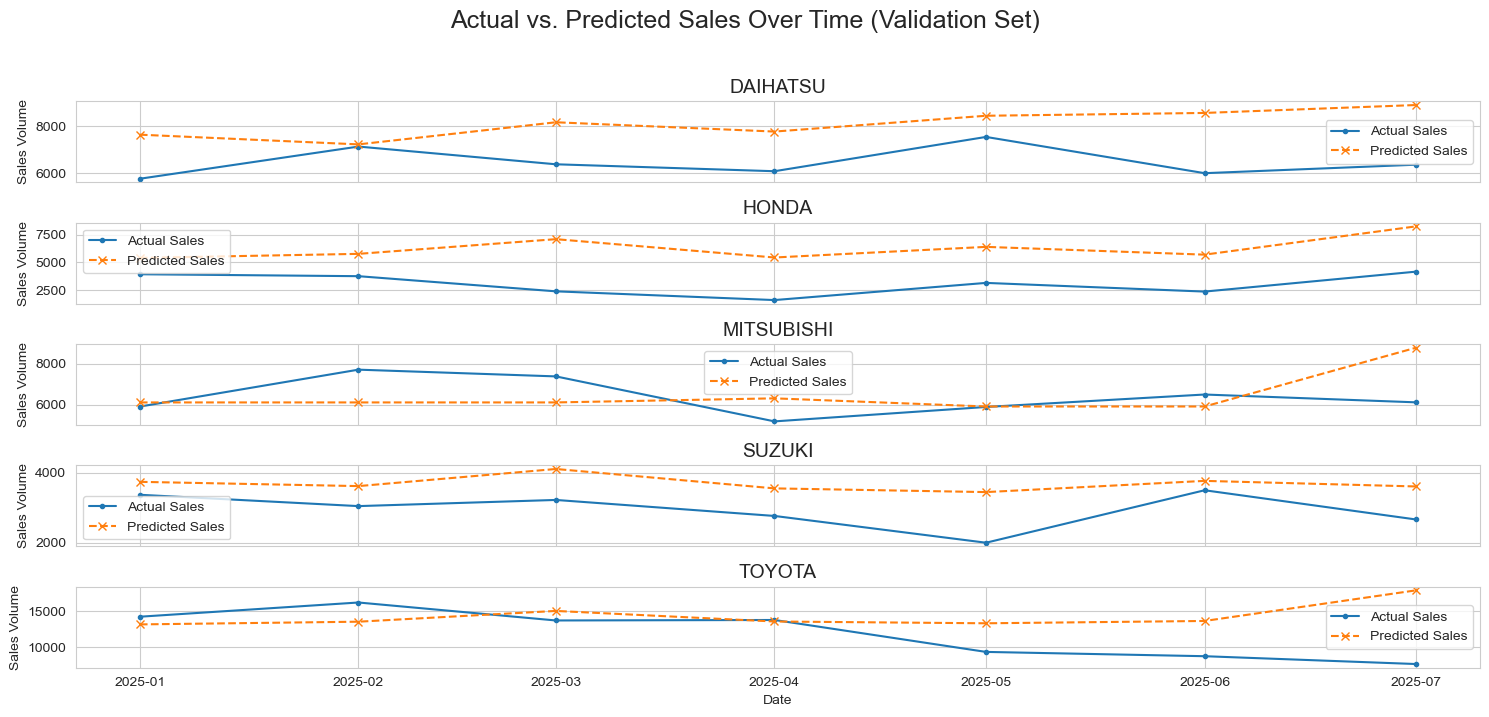

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style('whitegrid')

# Create subplots to visualize each model's predictions
# This will create a separate chart for each brand for clarity
fig, axes = plt.subplots(nrows=len(TARGETS), ncols=1, figsize = (15, 8), sharex=True)
fig.suptitle('Actual vs. Predicted Sales Over Time (Validation Set)', fontsize=18, y=0.92)

for i, target in enumerate(TARGETS):
    # Get the specific subplot
    ax = axes[i]
    
    # Use the trained model for the brand to make predictions
    y_pred = predictions_ensemble[target]
    
    # Plot the actual sales data from the validation set
    ax.plot(y_val.index, y_val[target], label='Actual Sales', marker='.', linestyle='-')
    
    # Plot the model's predicted sales on top
    ax.plot(y_val.index, y_pred, label='Predicted Sales', marker='x', linestyle='--')
    
    # Set titles and labels for clarity
    ax.set_title(target, fontsize=14)
    ax.set_ylabel('Sales Volume')
    ax.legend()

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()